# Universal $\mathcal{P}_1(\mathbb{R})$-Deep Neural Model (Type A)
---

---
# Training Algorithm:
---
## 1) Generate Data:
Generates the empirical measure $\sum_{n=1}^N \delta_{X_T(\omega_n)}$ of $X_T$ conditional on $X_0=x_0\in \mathbb{R}$ *($x_0$ and $T>0$ are user-provided)* by simulating from:
$$ 
X_T = x + \int_0^T \alpha(s,x)ds + \int_0^T\beta(s,x)dW_s.
$$

## 2) Get "Sample Barycenters":
Let $\{\mu_n\}_{n=1}^N\subset\mathcal{P}_1(\mathbb{R}^d)$.  Then, the *sample barycenter* is defined by:
1. $\mathcal{M}^{(0)}\triangleq \left\{\hat{\mu}_n\right\}_{n=1}^N$,
2. For $1\leq n\leq \mbox{N sample barycenters}$: 
    - $
\mu^{\star}\in \underset{\tilde{\mu}\in \mathcal{M}^{(n)}}{\operatorname{argmin}}\, \sum_{n=1}^N \mathcal{W}_1\left(\mu^{\star},\mu_n\right),
$
    - $\mathcal{M}^{(n)}\triangleq \mathcal{M}^{(n-1)} - \{\mu^{\star}\},$
*i.e., the closest generated measure form the random sample to all other elements of the random sample.*

---
**Note:** *We simplify the computational burden of getting the correct classes by putting this right into this next loop.*

## 3) Train Deep Classifier:
$\hat{f}\in \operatorname{argmin}_{f \in \mathcal{NN}_{d:N}^{\star}} 
\sum_{x \in \mathbb{X}}
\, 
\mathbb{H}
\left(
    \operatorname{Softmax}_N\circ f(x)_n| I\left\{W_1(\hat{\mu}_n,\mu_x),\inf_{m\leq N} W_1(\hat{\mu}_m,\mu_x)\right\}
\right);
$
where $\mathbb{H}$ is the categorical cross-entropy.  

---
---
---
## Notes - Why the procedure is so computationally efficient?
---
 - The sample barycenters do not require us to solve for any new Wasserstein-1 Barycenters; which is much more computationally costly,
 - Our training procedure never back-propages through $\mathcal{W}_1$ since steps 2 and 3 are full-decoupled.  Therefore, training our deep classifier is (comparatively) cheap since it takes values in the standard $N$-simplex.

---

## Meta-Parameters

### Visualization

In [1]:
# How many random polulations to visualize:
Visualization_Size = 4

### Quantization
*This hyperparameter describes the proportion of the data used as sample-barycenters.*

In [2]:
Quantization_Proportion = 1

### Simulation

In [74]:
## Monte-Carlo
N_Euler_Maruyama_Steps = 50
N_Monte_Carlo_Samples = 10**3
N_Monte_Carlo_Samples_Test = 10**3 # How many MC-samples to draw from test-set?

# Roughness
Rougness = 0.9
Ratio_fBM_to_typical_vol = 0

T_end = 1
Direct_Sampling = False #This hyperparameter determines if we use a Euler-Maryama scheme or if we use something else.  

## Grid
N_Grid_Finess = 50
Max_Grid = 1

**Note**: Setting *N_Quantizers_to_parameterize* prevents any barycenters and sub-sampling.

#### Mode: Code-Testin Parameter(s)

In [75]:
trial_run = True

### Meta-parameters

In [76]:
# Test-size Ratio
test_size_ratio = .75

## SDE Simulation Hyper-Parameter(s)

### Drift

In [77]:
def alpha(t,x):
    return np.sin(math.pi*x) + np.exp(-t)

### Volatility

In [78]:
def beta(t,x):
    return t + np.cos(x)

### Get Paths

In [79]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [80]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
# %run ParaGAN_Backend.ipynb
# exec(open('ParaGAN_Backend.py').read())
exec(open('Helper_Functions.py').read())
# Import time separately
import time

Deep Feature Builder - Ready
Deep Classifier - Ready


### Set Seed

In [81]:
random.seed(2021)
np.random.seed(2021)
tf.random.set_seed(2021)

## Get Internal (Hyper)-Parameter(s)
*Initialize the hyperparameters which are fully-specified by the user-provided hyperparameter(s).*

### Initialize Grid
This is $\mathbb{X}$ and it represents the grid of initial states.

In [82]:
# Get Input Data
#----------------------------------------------------------#
## Train
x_Grid = np.arange(start=-Max_Grid,
                   stop=Max_Grid,
                   step=(2*Max_Grid/N_Grid_Finess))
## Get Number of Instances in Grid: Training
N_Grid_Instances = len(x_Grid)

#----------------------------------------------------------#
## Test
x_Grid_test = np.sort(np.random.uniform(low=-Max_Grid,
                                        high=Max_Grid,
                                        size = round(N_Grid_Instances*test_size_ratio)))
# Get Number of Instances in Grid: Test
N_Grid_Instances_test = len(x_Grid_test)
#----------------------------------------------------------#

# Updater User
print("\u2022 Grid Instances: ", N_Grid_Instances, "and :",N_Grid_Instances_test," Testing instances.")

• Grid Instances:  50 and : 38  Testing instances.


### Initialize Counting Parameters
Initialize the "conting" type parameters which will help us to determine the length of loops and to intialize object's size later on.  

In [83]:
# Get Internal (Counting) Parameters
N_Quantizers_to_parameterize = round(Quantization_Proportion*N_Grid_Finess)
N_Elements_Per_Cluster = int(round(N_Grid_Instances/N_Quantizers_to_parameterize))

# Update User
print("\u2022",N_Quantizers_to_parameterize," Centers will be produced; from a total datasize of: ",N_Grid_Finess,
      "!  (That's ",Quantization_Proportion,
      " percent).")
print("\u2022 Each Wasserstein-1 Ball should contain: ",
      N_Elements_Per_Cluster, 
      "elements from the training set.")

• 50  Centers will be produced; from a total datasize of:  50 !  (That's  1  percent).
• Each Wasserstein-1 Ball should contain:  1 elements from the training set.


---

### Simulate "Rough" SDE:
$d X_t = \alpha(t,x)dt + (\beta(t,x)+\sigma_t^H)dW_t ;\qquad X_0 =x$
Where $(\sigma_t^H)_t$ is a fBM with Hurst parameter $H=0.01$.  

### Define Sampler - Data-Generator

Generates the empirical measure $\sum_{n=1}^N \delta_{X_T(\omega_n)}$ of $X_T$ conditional on $X_0=x_0\in \mathbb{R}$ *($x_0$ and $T>0$ are user-provided)*.

In [84]:
def Euler_Maruyama_Generator(x_0,
                             N_Euler_Maruyama_Steps = 100,
                             N_Monte_Carlo_Samples = 100,
                             T = 1,
                             Hurst = 0.01,
                             Ratio_fBM_to_typical_vol = 0.5): 
    
    #----------------------------#    
    # DEFINE INTERNAL PARAMETERS #
    #----------------------------#
    # Initialize Empirical Measure
    X_T_Empirical = np.zeros(N_Monte_Carlo_Samples)


    # Internal Initialization(s)
    ## Initialize current state
    n_sample = 0
    ## Initialize Incriments
    dt = T/N_Euler_Maruyama_Steps
    sqrt_dt = np.sqrt(dt)

    #-----------------------------#    
    # Generate Monte-Carlo Sample #
    #-----------------------------#
    while n_sample < N_Monte_Carlo_Samples:
        # Reset Step Counter
        t = 1
        # Initialize Current State 
        X_current = x_0
        # Generate roughness
        sigma_rough = FBM(n=N_Euler_Maruyama_Steps, hurst=0.75, length=1, method='daviesharte').fbm()
        # Perform Euler-Maruyama Simulation
        while t<N_Euler_Maruyama_Steps:
            # Update Internal Parameters
            ## Get Current Time
            t_current = t*(T/N_Euler_Maruyama_Steps)

            # Update Generated Path
            drift_t = alpha(t_current,X_current)*dt
            vol_t = ((1-Ratio_fBM_to_typical_vol)*beta(t_current,X_current)+Ratio_fBM_to_typical_vol*(sigma_rough[t]))*np.random.normal(0,sqrt_dt)
            X_current = X_current + drift_t + vol_t

            # Update Counter (EM)
            t = t+1

        # Update Empirical Measure
        X_T_Empirical[n_sample] = X_current

        # Update Counter (MC)
        n_sample = n_sample + 1

    return X_T_Empirical

---

### Initializations

In [85]:
# Initialize List of Barycenters
Wasserstein_Barycenters = []
# Initialize Terminal-Time Empirical Measures
## Training Outputs
measures_locations_list = []
measures_weights_list = []
## Testing Outputs
measures_locations_test_list = []
measures_weights_test_list = []

# Initialize (Empirical) Weight(s)
measure_weights = np.ones(N_Monte_Carlo_Samples)/N_Monte_Carlo_Samples
measure_weights_test = np.ones(N_Monte_Carlo_Samples_Test)/N_Monte_Carlo_Samples_Test
# Initialize Quantizer
Init_Quantizer_generic = np.ones(N_Monte_Carlo_Samples)/N_Monte_Carlo_Samples

## Generate $\{\hat{\nu}^{N}_{T,x}\}_{x \in \mathbb{X}}$ Build Wasserstein Cover

#### Get Data

In [86]:
# Update User
print("Current Monte-Carlo Step:")
if Direct_Sampling == True:
    print("Using Euler-Maruyama distritization + Monte-Carlo Sampling.")
else:
    print("Using Monte-Carlo Sampling directly from measure at time-T of X_T.")

print("===================================")
print("Start Simulation Step: Training Set")
print("===================================")
# Perform Monte-Carlo Data Generation
for i in tqdm(range(N_Grid_Instances)):
    # Get Terminal Distribution Shape
    ###
    
    if Direct_Sampling == True:
        # DIRECT SAMPLING
        measures_locations_loop = (np.random.normal(alpha(1,x_Grid[i]),
                                                    beta(1,x_Grid[i]),
                                                    N_Monte_Carlo_Samples).reshape(-1,))/N_Monte_Carlo_Samples
    else:
        measures_locations_loop = Euler_Maruyama_Generator(x_0=x_Grid[i],
                                                           N_Euler_Maruyama_Steps = N_Euler_Maruyama_Steps,
                                                           N_Monte_Carlo_Samples = N_Monte_Carlo_Samples,
                                                           T = T_end,
                                                           Hurst=Rougness,
                                                           Ratio_fBM_to_typical_vol=Ratio_fBM_to_typical_vol)
    
    # Append to List
    measures_locations_list.append(measures_locations_loop.reshape(-1,1))
    measures_weights_list.append(measure_weights)
    
# Update User
print("==================================")
print("Done Simulation Step: Training Set")
print("==================================")

#----------------------------------------------------------------------------------------------#

# Perform Monte-Carlo Data Generation
print("===============================")
print("Start Simulation Step: Test Set")
print("===============================")
for i in tqdm(range(N_Grid_Instances_test)):
    # Get Terminal Distribution Shape
    ###
    
     
    if Direct_Sampling == True:
        # DIRECT SAMPLING
        measures_locations_test_loop = (np.random.normal(alpha(1,x_Grid[i]),
                                                    beta(1,x_Grid[i]),
                                                    N_Monte_Carlo_Samples_Test).reshape(-1,))/N_Monte_Carlo_Samples_Test
    else:
        measures_locations_test_loop = Euler_Maruyama_Generator(x_0=x_Grid[i],
                                                                N_Euler_Maruyama_Steps = N_Euler_Maruyama_Steps,
                                                                N_Monte_Carlo_Samples = N_Monte_Carlo_Samples_Test,
                                                                T = T_end,
                                                                Hurst=Rougness,
                                                                Ratio_fBM_to_typical_vol=Ratio_fBM_to_typical_vol)
    
    
    # Append to List
    measures_locations_test_list.append(measures_locations_test_loop.reshape(-1,1))
    measures_weights_test_list.append(measure_weights_test)
    
# Update User
print("===============================")
print("Start Simulation Step: Test Set")
print("===============================")

  0%|          | 0/50 [00:00<?, ?it/s]

Current Monte-Carlo Step:
Using Monte-Carlo Sampling directly from measure at time-T of X_T.
Start Simulation Step: Training Set


  0%|          | 0/38 [00:00<?, ?it/s]

Done Simulation Step: Training Set
Start Simulation Step: Test Set


100%|██████████| 38/38 [01:21<00:00,  2.14s/it]

Start Simulation Step: Test Set


#### Start Timer (Model Type A)

In [87]:
# Start Timer
Type_A_timer_Begin = time.time()

## Get "Sample Barycenters":
Let $\{\mu_n\}_{n=1}^N\subset\mathcal{P}_1(\mathbb{R}^d)$.  Then, the *sample barycenter* is defined by:
1. $\mathcal{M}^{(0)}\triangleq \left\{\hat{\mu}_n\right\}_{n=1}^N$,
2. For $1\leq n\leq \mbox{N sample barycenters}$: 
    - $
\mu^{\star}\in \underset{\tilde{\mu}\in \mathcal{M}^{(n)}}{\operatorname{argmin}}\, \sum_{n=1}^N \mathcal{W}_1\left(\mu^{\star},\mu_n\right),
$
    - $\mathcal{M}^{(n)}\triangleq \mathcal{M}^{(n-1)} - \{\mu^{\star}\},$
*i.e., the closest generated measure form the random sample to all other elements of the random sample.*

---
**Note:** *We simplify the computational burden of getting the correct classes by putting this right into this next loop.*

---

## Build Dissimilarity (Distance) Matrix
*In this step we build a dissimularity matrix of the dataset on the Wasserstein-1 space.  Namely:*
$$
\operatorname{Mat}_{\# \mathbb{X},\# \mathbb{X}}\left(\mathbb{R}\right)\ni D; \text{ where}\qquad \, D_{i,j}\triangleq \mathcal{W}_1\left(f(x_i),f(x_j)\right)
;
$$
*where $f\in C\left((\mathcal{X},\mathcal{P}_1(\mathcal{Y})\right)$ is the "target" function we are learning.*

**Note**: *Computing the dissimularity matrix is the most costly part of the entire algorithm with a complexity of at-most $\mathcal{O}\left(E_{W} \# \mathbb{X})^2\right)$ where $E_W$ denotes the complexity of a single Wasserstein-1 evaluation between two elements of the dataset.*

In [88]:
# Initialize Disimilarity Matrix
Dissimilarity_matrix_ot = np.zeros([N_Grid_Instances,N_Grid_Instances])


# Update User
print("\U0001F61A"," Begin Building Distance Matrix"," \U0001F61A")
# Build Disimilarity Matrix
for i in tqdm(range(N_Grid_Instances)):
    for j in range(N_Grid_Instances):
        Dissimilarity_matrix_ot[i,j] = ot.emd2_1d(measures_locations_list[j],
                                                  measures_locations_list[i])
# Update User
print("\U0001F600"," Done Building Distance Matrix","\U0001F600","!")

 12%|█▏        | 6/50 [00:00<00:00, 59.55it/s]

😚  Begin Building Distance Matrix  😚


100%|██████████| 50/50 [00:00<00:00, 64.80it/s]

😀  Done Building Distance Matrix 😀 !


## Initialize Quantities to Loop Over

## Get "Sample Barycenters" and Generate Classes

In [89]:
# Initialize Locations Matrix (Internal to Loop)
measures_locations_list_current = copy.copy(measures_locations_list)
Dissimilarity_matrix_ot_current = copy.copy(Dissimilarity_matrix_ot)

# Initialize masker vector
masker = np.ones(N_Grid_Instances)

# Initialize Sorting Reference Vector (This helps us efficiently scroll through the disimularity matrix to identify the barycenter without having to re-compute the dissimultarity matrix of a sub-saple at every iteration (which is the most costly part of the algorithm!))
Distances_Loop = Dissimilarity_matrix_ot_current.sum(axis=1)

# Initialize Classes (In-Sample)
Classifer_Wasserstein_Centers = np.zeros([N_Quantizers_to_parameterize,N_Grid_Instances])

In [90]:
# Update User
print("\U0001F61A"," Begin Identifying Sample Barycenters"," \U0001F61A")

# Identify Sample Barycenters
for i in tqdm(range(N_Quantizers_to_parameterize)):    
    # GET BARYCENTER #
    #----------------#
    ## Identify row with minimum total distance
    Barycenter_index = int(Distances_Loop.argsort()[:1][0])
    ## Get Barycenter
    ## Update Barycenters Array ##
    #----------------------------#
    ### Get next Barycenter
    new_barycenter_loop = measures_locations_list_current[Barycenter_index].reshape(-1,1)
    ### Update Array of Barycenters
    if i == 0:
        # Initialize Barycenters Array
        Barycenters_Array = new_barycenter_loop
    else:
        # Populate Barycenters Array
        Barycenters_Array = np.append(Barycenters_Array,new_barycenter_loop,axis=-1)

    # GET CLUSTER #
    #-------------#
    # Identify Cluster for this barycenter (which elements are closest to it)
    Cluster_indices = (masker*Dissimilarity_matrix_ot_current[:,Barycenter_index]).argsort()[:N_Elements_Per_Cluster]
    ## UPDATES Set  M^{(n)}  ##
    #-------------------------#
    Dissimilarity_matrix_ot_current[Cluster_indices,:] = 0
    # Distance-Based Sorting
    Distances_Loop[Cluster_indices] = math.inf

    # Update Cluster
    masker[Cluster_indices] = math.inf
    
    # Update Classes
    Classifer_Wasserstein_Centers[i,Cluster_indices] = 1
#     print(Cluster_indices)

# Update User
print("\U0001F600"," Done Identifying Sample Barycenters","\U0001F600","!")
print(Classifer_Wasserstein_Centers)

100%|██████████| 50/50 [00:00<00:00, 10483.66it/s]

😚  Begin Identifying Sample Barycenters  😚
😀  Done Identifying Sample Barycenters 😀 !
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


---

### Train Deep Classifier

In this step, we train a deep (feed-forward) classifier:
$$
\hat{f}\triangleq \operatorname{Softmax}_N\circ W_J\circ \sigma \bullet \dots \sigma \bullet W_1,
$$
to identify which barycenter we are closest to.

Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.

#### Train Deep Classifier

In [91]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Classifier Function(s)
exec(open('Helper_Functions.py').read())

Deep Feature Builder - Ready
Deep Classifier - Ready


In [92]:
# Redefine (Dimension-related) Elements of Grid
# param_grid_Deep_Classifier['input_dim'] = [1]
param_grid_Deep_Classifier['output_dim'] = [N_Quantizers_to_parameterize]

# Train simple deep classifier
predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter = n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = x_Grid, 
                                                                                                        y_train = Classifer_Wasserstein_Centers.T,
                                                                                                        X_test = x_Grid_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.4s finished


2/2 [==============================] - 0s 1ms/step


#### Get Predicted Quantized Distributions
- Each *row* of "Predicted_Weights" is the $\beta\in \Delta_N$.
- Each *Column* of "Barycenters_Array" denotes the $x_1,\dots,x_N$ making up the points of the corresponding empirical measures.

In [93]:
# Format Weights
## Train
print("#---------------------------------------#")
print("Building Training Set (Regression): START")
print("#---------------------------------------#")
Predicted_Weights = np.array([])
for i in tqdm(range(N_Quantizers_to_parameterize)):    
    b = np.repeat(np.array(predicted_classes_train[:,i],dtype='float').reshape(-1,1),N_Monte_Carlo_Samples,axis=-1)
    b = b/N_Monte_Carlo_Samples
    if i ==0 :
        Predicted_Weights = b
    else:
        Predicted_Weights = np.append(Predicted_Weights,b,axis=1)
print("#-------------------------------------#")
print("Building Training Set (Regression): END")
print("#-------------------------------------#")

## Test
print("#-------------------------------------#")
print("Building Test Set (Predictions): START")
print("#-------------------------------------#")
Predicted_Weights_test = np.array([])
for i in tqdm(range(N_Quantizers_to_parameterize)):
    b_test = np.repeat(np.array(predicted_classes_test[:,i],dtype='float').reshape(-1,1),N_Monte_Carlo_Samples,axis=-1)
    b_test = b_test/N_Monte_Carlo_Samples
    if i ==0 :
        Predicted_Weights_test = b_test
    else:
        Predicted_Weights_test = np.append(Predicted_Weights_test,b_test,axis=1)
print("#-----------------------------------#")
print("Building Test Set (Predictions): END")
print("#-----------------------------------#")
        
# Format Points of Mass
print("#-----------------------------#")
print("Building Barycenters Set: START")
print("#-----------------------------#")
Barycenters_Array = Barycenters_Array.T.reshape(-1,)
print("#-----------------------------#")
print("Building Barycenters Set: END")
print("#-----------------------------#")

  0%|          | 0/50 [00:00<?, ?it/s]

#---------------------------------------#
Building Training Set (Regression): START
#---------------------------------------#


  0%|          | 0/50 [00:00<?, ?it/s]

#-------------------------------------#
Building Training Set (Regression): END
#-------------------------------------#
#-------------------------------------#
Building Test Set (Predictions): START
#-------------------------------------#


100%|██████████| 50/50 [00:00<00:00, 566.14it/s]

#-----------------------------------#
Building Test Set (Predictions): END
#-----------------------------------#
#-----------------------------#
Building Barycenters Set: START
#-----------------------------#
#-----------------------------#
Building Barycenters Set: END
#-----------------------------#


#### Stop Timer

In [94]:
# Stop Timer
Type_A_timer_end = time.time()
# Compute Lapsed Time Needed For Training
Time_Lapse_Model_A = Type_A_timer_end - Type_A_timer_Begin

## Get Moment Predictions

#### Write Predictions

### Training-Set Result(s): 

In [118]:
print("Building Training Set Performance Metrics")

# Initialize Wasserstein-1 Error Distribution
W1_errors = np.array([])
Mean_errors = np.array([])
Var_errors = np.array([])
Skewness_errors = np.array([])
Kurtosis_errors = np.array([])
#---------------------------------------------------------------------------------------------#

# Populate Error Distribution
for x_i in tqdm(range(len(measures_locations_list)-1)):    
    # Get Laws
    W1_loop = ot.emd2_1d(Barycenters_Array,
                         measures_locations_list[x_i].reshape(-1,),
                         Predicted_Weights[x_i,].reshape(-1,),
                         measures_weights_list[x_i].reshape(-1,))
    W1_errors = np.append(W1_errors,W1_loop)
    # Get Means
    Mu_hat = np.sum((Predicted_Weights[x_i])*(Barycenters_Array))
    Mu = np.mean(measures_locations_list[x_i])
    Mean_errors =  np.append(Mean_errors,(Mu_hat-Mu))
    # Get Var (non-centered)
    Var_hat = np.sum((Barycenters_Array**2)*(Predicted_Weights[x_i]))
    Var = np.mean(measures_locations_list[x_i]**2)
    Var_errors = np.append(Var_errors,(Var_hat-Var)**2)
    # Get skewness (non-centered)
    Skewness_hat = np.sum((Barycenters_Array**3)*(Predicted_Weights[x_i]))
    Skewness = np.mean(measures_locations_list[x_i]**3)
    Skewness_errors = np.append(Skewness_errors,(abs(Skewness_hat-Skewness))**(1/3))
    # Get skewness (non-centered)
    Kurtosis_hat = np.sum((Barycenters_Array**4)*(Predicted_Weights[x_i]))
    Kurtosis = np.mean(measures_locations_list[x_i]**4)
    Kurtosis_errors = np.append(Kurtosis_errors,(abs(Kurtosis_hat-Kurtosis))**.25)
    
#---------------------------------------------------------------------------------------------#
# Compute Error Statistics/Descriptors
W1_Performance = np.array([np.mean(np.abs(W1_errors)),np.mean(W1_errors**2)])
Mean_prediction_Performance = np.array([np.mean(np.abs(Mean_errors)),np.mean(Mean_errors**2)])
Var_prediction_Performance = np.array([np.mean(np.abs(Var_errors)),np.mean(Var_errors**2)])
Skewness_prediction_Performance = np.array([np.mean(np.abs(Skewness_errors)),np.mean(Skewness_errors**2)])
Kurtosis_prediction_Performance = np.array([np.mean(np.abs(Kurtosis_errors)),np.mean(Kurtosis_errors**2)])

Type_A_Prediction = pd.DataFrame({"W1":W1_Performance,
                                  "E[X']-E[X]":Mean_prediction_Performance,
                                  "(E[X'^2]-E[X^2])^.5":Var_prediction_Performance,
                                  "(E[X'^3]-E[X^3])^(1/3)":Skewness_prediction_Performance,
                                  "(E[X'^4]-E[X^4])^.25":Kurtosis_prediction_Performance},index=["MAE","MSE"])

# Write Performance
Type_A_Prediction.to_latex((results_tables_path+str("Roughness_")+str(Rougness)+str("__RatiofBM_")+str(Ratio_fBM_to_typical_vol)+
 "__TypeAPrediction_Train.tex"))


#---------------------------------------------------------------------------------------------#
# Update User
print(Type_A_Prediction)

 16%|█▋        | 8/49 [00:00<00:00, 78.41it/s]

Building Training Set Performance Metrics


100%|██████████| 49/49 [00:00<00:00, 82.93it/s]

           W1  E[X']-E[X]  (E[X'^2]-E[X^2])^.5  (E[X'^3]-E[X^3])^(1/3)  \
MAE  0.481799    0.526085             0.081891                1.046953   
MSE  0.342156    0.341944             0.010176                1.153585   

     (E[X'^4]-E[X^4])^.25  
MAE              0.998363  
MSE              1.025540  


---

### Test-Set Result(s): 

In [119]:
print("Building Test Set Performance Metrics")

# Initialize Wasserstein-1 Error Distribution
W1_errors_test = np.array([])
Mean_errors_test = np.array([])
Var_errors_test = np.array([])
Skewness_errors_test = np.array([])
Kurtosis_errors_test = np.array([])
#---------------------------------------------------------------------------------------------#

# Populate Error Distribution
for x_i in tqdm(range(len(measures_locations_test_list)-1)):    
    # Get Laws
    W1_loop_test = ot.emd2_1d(Barycenters_Array,
                         measures_locations_test_list[x_i].reshape(-1,),
                         Predicted_Weights_test[x_i,].reshape(-1,),
                         measures_weights_test_list[x_i].reshape(-1,))
    W1_errors_test = np.append(W1_errors_test,W1_loop_test)
    # Get Means
    Mu_hat_test = np.sum((Predicted_Weights_test[x_i])*(Barycenters_Array))
    Mu_test = np.mean(measures_locations_test_list[x_i])
    Mean_errors_test =  np.append(Mean_errors_test,(Mu_hat_test-Mu_test))
    # Get Var (non-centered)
    Var_hat_test = np.sum((Barycenters_Array**2)*(Predicted_Weights_test[x_i]))
    Var_test = np.mean(measures_locations_test_list[x_i]**2)
    Var_errors_test = np.append(Var_errors_test,(Var_hat_test-Var_test)**2)
    # Get skewness (non-centered)
    Skewness_hat_test = np.sum((Barycenters_Array**3)*(Predicted_Weights_test[x_i]))
    Skewness_test = np.mean(measures_locations_test_list[x_i]**3)
    Skewness_errors_test = np.append(Skewness_errors_test,(abs(Skewness_hat_test-Skewness_test))**(1/3))
    # Get skewness (non-centered)
    Kurtosis_hat_test = np.sum((Barycenters_Array**4)*(Predicted_Weights_test[x_i]))
    Kurtosis_test = np.mean(measures_locations_test_list[x_i]**4)
    Kurtosis_errors_test = np.append(Kurtosis_errors_test,(abs(Kurtosis_hat_test-Kurtosis_test))**.25)
    
#---------------------------------------------------------------------------------------------#
# Compute Error Statistics/Descriptors
W1_Performance_test = np.array([np.mean(np.abs(W1_errors_test)),np.mean(W1_errors_test**2)])
Mean_prediction_Performance_test = np.array([np.mean(np.abs(Mean_errors_test)),np.mean(Mean_errors_test**2)])
Var_prediction_Performance_test = np.array([np.mean(np.abs(Var_errors_test)),np.mean(Var_errors_test**2)])
Skewness_prediction_Performance_test = np.array([np.mean(np.abs(Skewness_errors_test)),np.mean(Skewness_errors_test**2)])
Kurtosis_prediction_Performance_test = np.array([np.mean(np.abs(Kurtosis_errors_test)),np.mean(Kurtosis_errors_test**2)])

Type_A_Prediction_test = pd.DataFrame({"W1":W1_Performance_test,
                                  "E[X']-E[X]":Mean_prediction_Performance_test,
                                  "(E[X'^2]-E[X^2])^.5":Var_prediction_Performance_test,
                                  "(E[X'^3]-E[X^3])^(1/3)":Skewness_prediction_Performance_test,
                                  "(E[X'^4]-E[X^4])^.25":Kurtosis_prediction_Performance_test},index=["MAE","MSE"])

# Write Performance
Type_A_Prediction_test.to_latex((results_tables_path+str("Roughness_")+str(Rougness)+str("__RatiofBM_")+str(Ratio_fBM_to_typical_vol)+
 "__TypeAPrediction_Test.tex"))

 24%|██▍       | 9/37 [00:00<00:00, 84.96it/s]

Building Test Set Performance Metrics


100%|██████████| 37/37 [00:00<00:00, 95.49it/s]


## Update User

### Training-Set Performance

In [97]:
Type_A_Prediction

,W1,E[X']-E[X],(E[X'^2]-E[X^2])^.5,(E[X'^3]-E[X^3])^(1/3),(E[X'^4]-E[X^4])^.25
MAE,0.481799,0.526085,0.081891,1.046953,0.998363
MSE,0.342156,0.341944,0.010176,1.153585,1.025540


### Test-Set Performance

In [98]:
Type_A_Prediction_test

,W1,E[X']-E[X],(E[X'^2]-E[X^2])^.5,(E[X'^3]-E[X^3])^(1/3),(E[X'^4]-E[X^4])^.25
MAE,0.406361,0.475559,0.061407,0.995614,0.958622
MSE,0.285843,0.300031,0.006408,1.052079,0.943841


### Print for Terminal Legibility

In [99]:
print("#----------------------#")
print("Training-Set Performance")
print("#----------------------#")
print(Type_A_Prediction)
print(" ")
print(" ")
print(" ")

print("#------------------#")
print("Test-Set Performance")
print("#------------------#")
print(Type_A_Prediction_test)
print(" ")
print(" ")
print(" ")

#----------------------#
Training-Set Performance
#----------------------#
           W1  E[X']-E[X]  (E[X'^2]-E[X^2])^.5  (E[X'^3]-E[X^3])^(1/3)  \
MAE  0.481799    0.526085             0.081891                1.046953   
MSE  0.342156    0.341944             0.010176                1.153585   

     (E[X'^4]-E[X^4])^.25  
MAE              0.998363  
MSE              1.025540  
 
 
 
#------------------#
Test-Set Performance
#------------------#
           W1  E[X']-E[X]  (E[X'^2]-E[X^2])^.5  (E[X'^3]-E[X^3])^(1/3)  \
MAE  0.406361    0.475559             0.061407                0.995614   
MSE  0.285843    0.300031             0.006408                1.052079   

     (E[X'^4]-E[X^4])^.25  
MAE              0.958622  
MSE              0.943841  
 
 
 


# Visualization of Performance
Randomly subsample from output space and visualize empirical measures!

In [29]:
# # Adjust if is number of plots to visualizes is larger than number of output distributions (But only if there is not enough data!)
# if N_Grid_Instances <= Visualization_Size**2:
#         Visualization_Size = int(round(np.sqrt(min(N_Grid_Instances,Visualization_Size**2)))-1)


# # Initialize Random Sample of input-output pairs to visualize
# plotting_distribution_indices = random.sample(range(N_Grid_Instances), (Visualization_Size)**2)

# # Generate Plot
# f, axarr = plt.subplots(Visualization_Size,Visualization_Size,figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.suptitle("Sample of Predictions")
# for i in range(Visualization_Size):
#     for j in range(Visualization_Size):
#         # Get Current (Randomly chosen (uniformly)) Index
#         current_index = (i*Visualization_Size + j)
#         current_random_index = plotting_distribution_indices[current_index]
#         # Generate Current Plot
#         axarr[i,j].bar(Barycenters_Array,(Predicted_Weights[current_random_index].reshape(-1,)), alpha=0.5,label="Prediction",color="chartreuse")
#         axarr[i,j].bar(measures_locations_list[current_random_index].reshape(-1,),measures_weights_list[current_random_index], alpha=0.5,label="Target",color="purple")

---

# Benchmark: SDE-Net

Credits for this implementation of SDE-Net go to the author of the GitHub repository: [https://github.com/Junghwan-brian/SDE-Net](https://github.com/Junghwan-brian/SDE-Net). 
*cloned on April 3$^{rd}$ 2021.*

This method is explored in the recent 2020 ICML paper: [Code for paper: SDE-Net: Equipping Deep Neural network with Uncertainty Estimates](http://proceedings.mlr.press/v119/kong20b.html) by: *Lingkai Kong, Jimeng Sun, and Chao Zhang*.

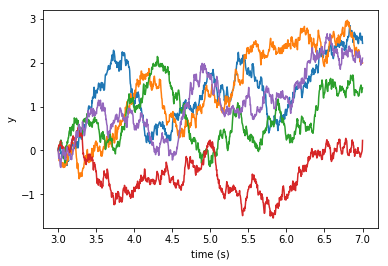

In [30]:
import numpy as np
import matplotlib.pyplot as plt

num_sims = 5  # Display five runs

t_init = 3
t_end = 7
N = 1000  # Compute 1000 grid points
dt = float(t_end - t_init) / N
y_init = 0

c_theta = 0.7
c_mu = 1.5
# if you increase sigma, diffusion is increases. 
c_sigma = 1


def mu(y, t):
    """Implement the Ornstein–Uhlenbeck mu."""  # = \theta (\mu-Y_t)
    return c_theta * (c_mu - y)


def sigma(y, t):
    """Implement the Ornstein–Uhlenbeck sigma."""  # = \sigma
    return c_sigma


def dW(delta_t):
    """Sample a random number at each call."""
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))


ts = np.arange(t_init, t_end + dt, dt)
ys = np.zeros(N + 1)

ys[0] = y_init

for _ in range(num_sims):
    for i in range(1, ts.size):
        t = (i - 1) * dt
        y = ys[i - 1]
        ys[i] = y + mu(y, t) * dt + sigma(y, t) * dW(dt)
    plt.plot(ts, ys)

plt.xlabel("time (s)")
h = plt.ylabel("y")
plt.show()

## Custom Tensorflow Layer(s)

In [31]:
## Drift Layer
class Drift(tf.keras.layers.Layer):
    def __init__(self):
        super(Drift, self).__init__(name="drift_net")
        self.fc = Dense(50)  # input : 50
        self.relu = ReLU()

    def call(self, t, x):
        out = self.relu(self.fc(x))
        return out
    
## Diffusion Layer
class Diffusion(tf.keras.layers.Layer):
    def __init__(self):
        super(Diffusion, self).__init__(name="diffusion_net")
        self.relu = ReLU()
        self.fc1 = Dense(100)  # input : 50
        self.fc2 = Dense(1)  # input : 100

    def call(self, t, x):
        out = self.relu(self.fc1(x))
        out = self.fc2(out)
        out = tf.nn.sigmoid(out)
        return out  # batch,1

## SDE-Net Model:

In [32]:
class SDENet(tf.keras.Model):
    def __init__(self, layer_depth):
        super(SDENet, self).__init__(name="SDE_Net")
        self.layer_depth = layer_depth
        self.downsampling_layers = Dense(50)  # batch, 50
        self.drift = Drift()  # batch, 1
        self.diffusion = Diffusion()
        self.fc_layers = Sequential(
            [ReLU(), Dense(2)]
        )  # input : 50, output : mean, variance
        self.deltat = 4.0 / self.layer_depth  # T:4, N:layer_depth
        self.sigma_max = 0.5  # sigma_max : scaling diffusion output

    def call(self, x, training_diffusion=False):
        out = self.downsampling_layers(x)
        if not training_diffusion:
            t = 0
            diffusion_term = self.sigma_max * self.diffusion(t, out)
            for i in range(self.layer_depth):
                t = 4 * (float(i)) / self.layer_depth
                out = (
                    out
                    + self.drift(t, out) * self.deltat
                    + diffusion_term
                    * tf.cast(tf.math.sqrt(self.deltat), "float64")
                    * tf.random.normal(tf.shape(out), dtype="float64")
                )  # Euler-Maruyama method

            final_out = self.fc_layers(out)
            mean = final_out[:, 0]
            # sigma should be greater than 0.
            sigma = tf.math.softplus(final_out[:, 1]) + 1e-3
            return mean, sigma

        else:
            t = 0
            final_out = self.diffusion(t, out)
            return final_out

## Training of SDE-Net

In [33]:
real_label = 0
fake_label = 1

@tf.function
def train_net(x, y):
    with tf.GradientTape(persistent=True) as tape:
        mean, sigma = model(x, training_diffusion=False)
        loss = nll_loss(y, mean, sigma)

    drift_gradient = tape.gradient(loss, model.drift.trainable_variables)
    dsl_gradient = tape.gradient(loss, model.downsampling_layers.trainable_variables)
    fc_gradient = tape.gradient(loss, model.fc_layers.trainable_variables)

    drift_gradient = [(tf.clip_by_norm(grad, 100)) for grad in drift_gradient]
    dsl_gradient = [(tf.clip_by_norm(grad, 100)) for grad in dsl_gradient]
    fc_gradient = [(tf.clip_by_norm(grad, 100)) for grad in fc_gradient]

    optimizer_drift.apply_gradients(
        zip(drift_gradient, model.drift.trainable_variables)
    )
    optimizer_dsl.apply_gradients(
        zip(dsl_gradient, model.downsampling_layers.trainable_variables)
    )
    optimizer_fc.apply_gradients(zip(fc_gradient, model.fc_layers.trainable_variables))
    train_loss(loss)

@tf.function
def train_diffusion(real_x):
    with tf.GradientTape(watch_accessed_variables=False) as real_tape_diffusion:
        # only access to diffusion layer's parameters
        real_tape_diffusion.watch(model.diffusion.trainable_variables)
        real_y = tf.fill((real_x.shape[0], 1), real_label)
        real_pred = model(real_x, training_diffusion=True)
        real_loss = mse(real_y, real_pred)

    diffusion_gradient = real_tape_diffusion.gradient(
        real_loss, model.diffusion.trainable_variables
    )

    diffusion_gradient1 = [(tf.clip_by_norm(grad, 100)) for grad in diffusion_gradient]

    with tf.GradientTape(watch_accessed_variables=False) as fake_tape_diffusion:
        fake_tape_diffusion.watch(model.diffusion.trainable_variables)
        # fake std is 2 in official code, but in paper it is 4
        fake_x = (
            tf.cast(
                tf.random.normal((real_x.shape[0], 90), mean=0, stddev=2), "float64"
            )
            + real_x
        )
        fake_y = tf.fill((real_x.shape[0], 1), fake_label)
        fake_pred = model(fake_x, training_diffusion=True)
        fake_loss = mse(fake_y, fake_pred)

    diffusion_gradient = fake_tape_diffusion.gradient(
        fake_loss, model.diffusion.trainable_variables
    )

    diffusion_gradient2 = [(tf.clip_by_norm(grad, 100)) for grad in diffusion_gradient]

    diffusion_gradient = [
        grad1 + grad2 for grad1, grad2 in zip(diffusion_gradient1, diffusion_gradient2)
    ]

    optimizer_diffusion.apply_gradients(
        zip(diffusion_gradient, model.diffusion.trainable_variables)
    )
    in_loss(real_loss)
    out_loss(fake_loss)

---
# Fin
---

---